In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=3, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd



## Systematic uncertainty variable

Load the data

In [2]:
with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)


posterior_nmma = pd.read_csv("./outdir_nmma/injection_gaussian_posterior_samples.dat", sep=" ", header=0)
posterior_fiesta = np.load("./outdir_fiesta/results_production.npz")
posterior_nmma_x_fiesta = pd.read_csv("./outdir_nmma_x_fiesta/injection_gaussian_posterior_samples.dat", sep=" ", header=0)
posterior_nmma_x_fiesta["sys_err"] = posterior_nmma_x_fiesta["em_syserr"]

Make corner plot

In [3]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B", "sys_err"]
truths = [params[key] for key in var_names[:-1]]
truths.append(None)

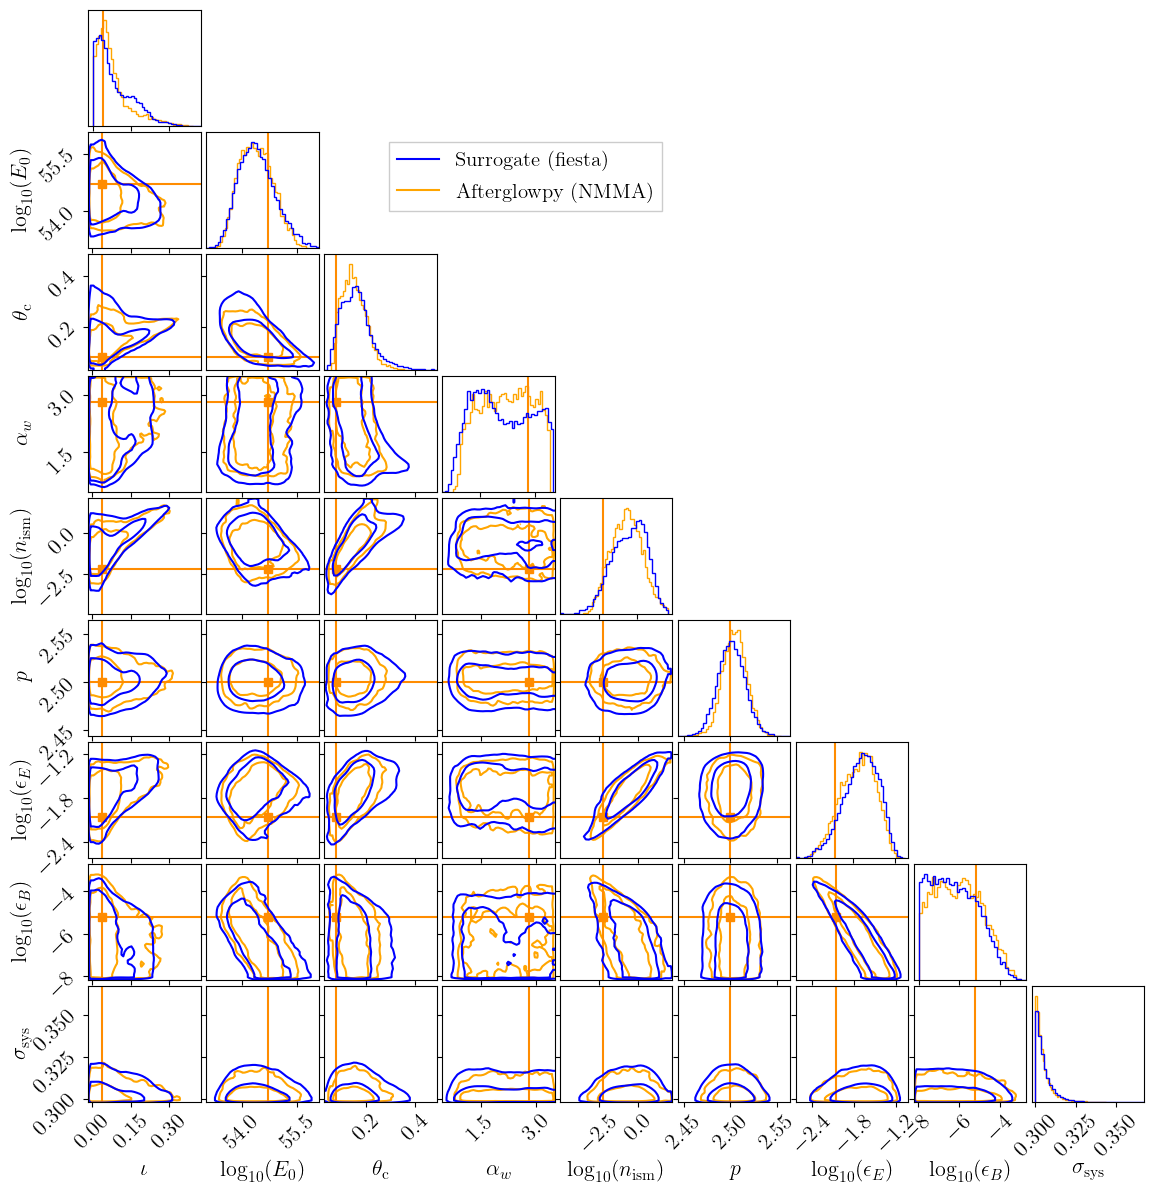

In [4]:
fig, ax = plt.subplots(9,9, figsize = (12, 12))


corner.corner(posterior_nmma[var_names], 
              truths = truths,
              fig=fig,
              color = "orange",
              labelpad=0.2,
              labels =  ["$\\iota$", "$\log_{10}(E_0)$", "$\\theta_{\\mathrm{c}}$", "$\\alpha_w$", "$\log_{10}(n_{\mathrm{ism}})$", "$p$", "$\log_{10}(\\epsilon_E)$", "$\log_{10}(\\epsilon_B)$", "$\\sigma_{\\rm sys}$"],
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

corner.corner((posterior_fiesta["chains"].reshape(-1, 9)),
              fig=fig,
              color="blue",
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

handles = []
for c in ["blue", "orange"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[1, 4].legend(handles=handles, labels=["Surrogate (fiesta)", "Afterglowpy (NMMA)"], fontsize=15, fancybox=False, framealpha=1)
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99)
plt.show()

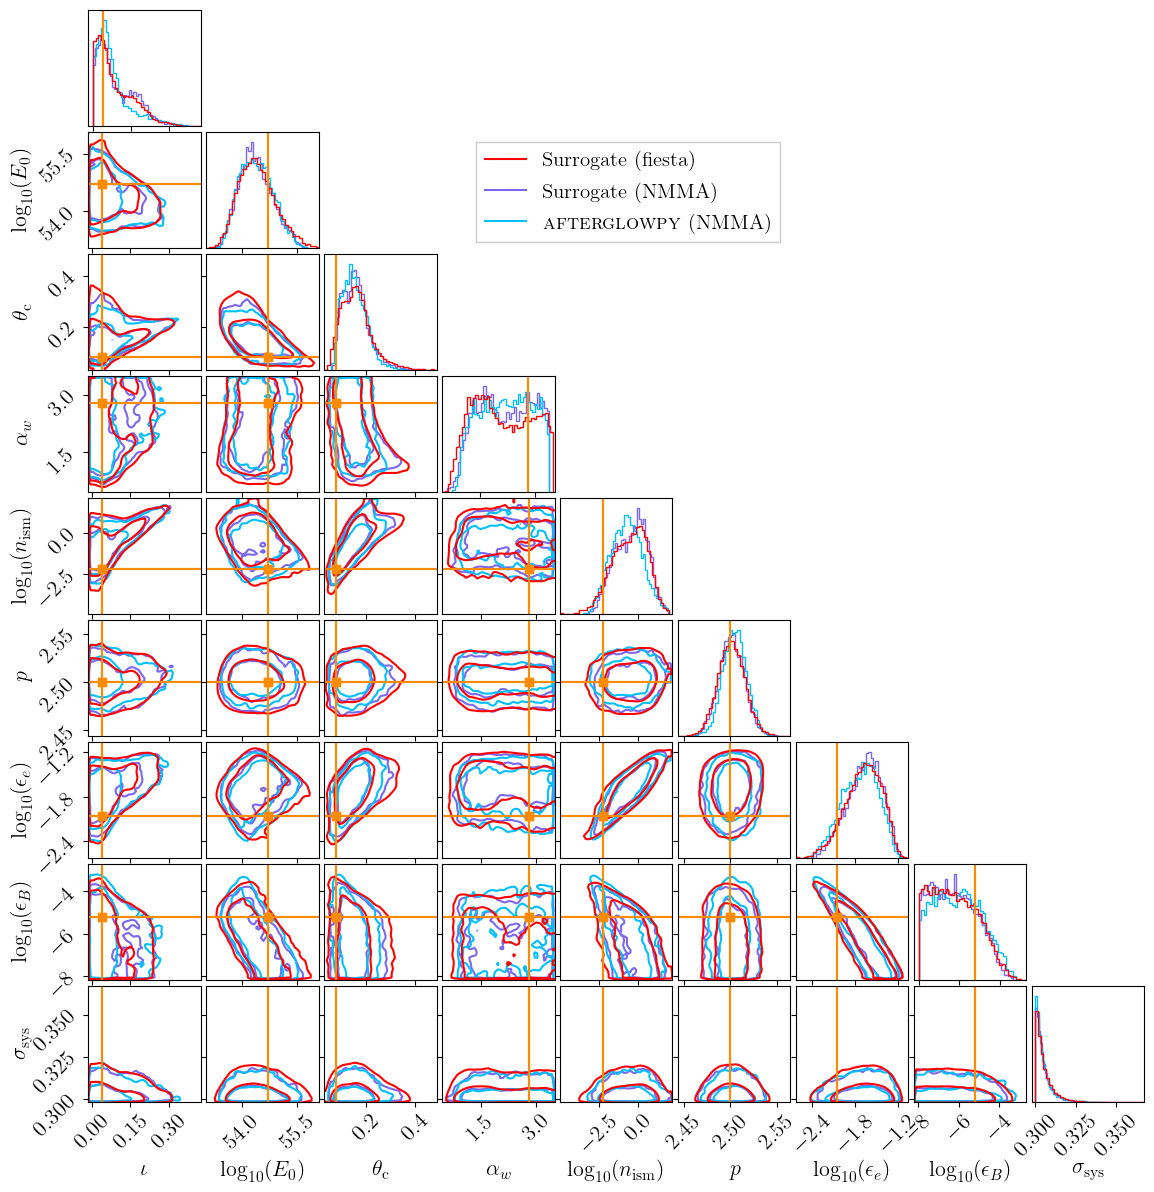

In [5]:
fig, ax = plt.subplots(9,9, figsize = (12, 12))


corner.corner(posterior_nmma_x_fiesta[var_names], 
              truths = truths,
              fig=fig,
             color = "mediumslateblue",
              labelpad=0.2,
              labels =  ["$\\iota$", "$\log_{10}(E_0)$", "$\\theta_{\\mathrm{c}}$", "$\\alpha_w$", "$\log_{10}(n_{\mathrm{ism}})$", "$p$", "$\log_{10}(\\epsilon_e)$", "$\log_{10}(\\epsilon_B)$", "$\\sigma_{\\rm sys}$"],
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

corner.corner(posterior_nmma[var_names],
              fig=fig,
              color="deepskyblue",
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

corner.corner((posterior_fiesta["chains"].reshape(-1, 9)),
              truths=truths,
              fig=fig,
              color="red",
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

handles = []
for c in ["red", "mediumslateblue", "deepskyblue"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[1, 5].legend(handles=handles, labels=["Surrogate (fiesta)", "Surrogate (NMMA)", "\\textsc{afterglowpy} (NMMA)"], fontsize=15, fancybox=False, framealpha=1)
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99)

fig.savefig("./figures/injection_afgpy_gaussian.pdf", dpi=250)
plt.show()

In [6]:
from fiesta.plot import corner_plot

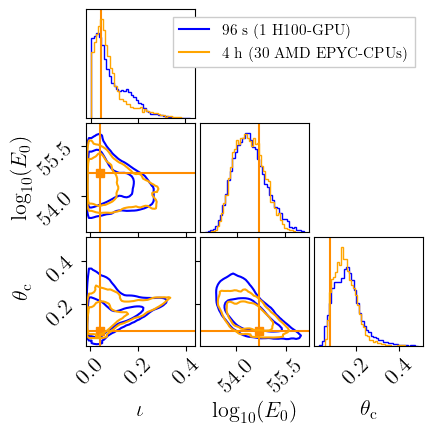

In [7]:
fig, ax = corner_plot(posterior_fiesta["chains"].reshape(-1, 9)[:, :3], parameter_names=var_names[:3], truths=truths[:3], color="blue")


corner.corner(posterior_nmma[var_names[:3]],
              fig=fig,
              color="orange",
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

handles = []
for c in ["blue", "orange"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[0, -1].legend(handles=handles, labels=["96 s (1 H100-GPU)", "4 h (30 AMD EPYC-CPUs)"], fontsize=11, fancybox=False, framealpha=1)
fig.subplots_adjust(bottom=0.2, left=0.2)
fig.savefig("small_corner.pdf", dpi=250)